# **Optimal Trading Portfolio from Mutual Funds**

This notebook provides a comprehensive framework for constructing an optimal investment portfolio from mutual funds using modern portfolio theory (MPT) and the Riskfolio-Lib Python library. We cover data preparation, risk-return analysis, portfolio optimization, and performance simulation.


## **Simulation**
## **Objective**
Simulate future portfolio returns to evaluate performance under different market conditions.
- We assume log returns follow a Normal Distribution for simplicity, though real-world returns often exhibit fat tails and skewness.
- The simulation uses:
Historical mean returns (μ)
Covariance matrix (Σ) of asset returns
Random returns are generated using:
R  ~ N(μ, Σ)

Why Normal Distribution?

Simplifies computation while providing a reasonable approximation.
Can be extended to more complex models (e.g., Student’s t-distribution, GARCH models).

~ Monte Carlo simulation can be applied for more robust analysis.

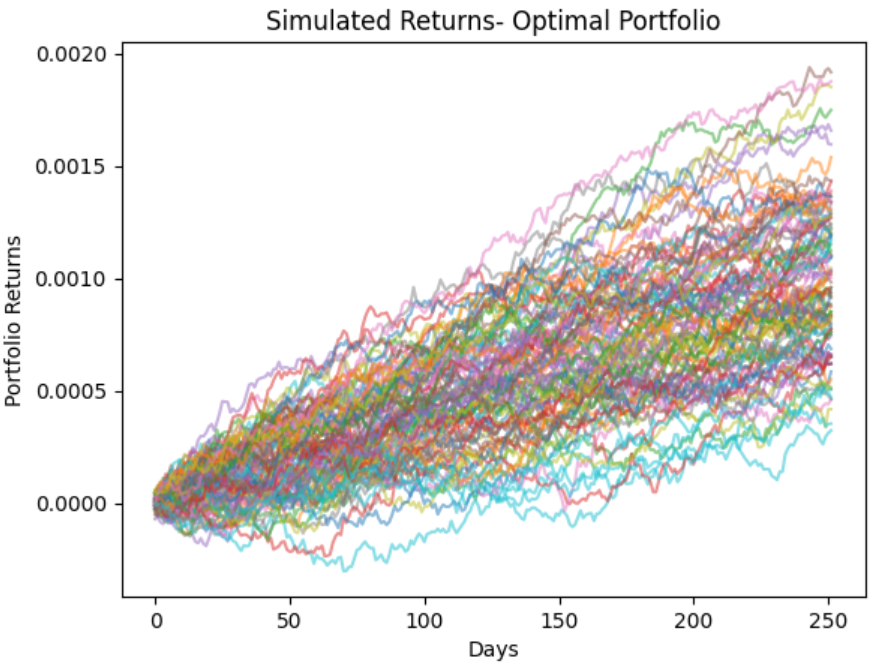
<!-- 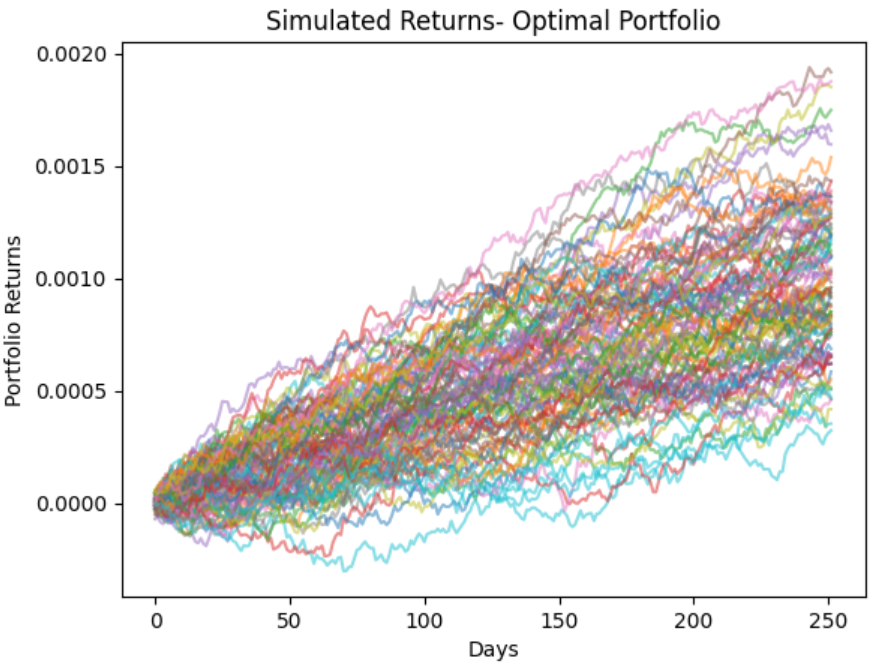
 -->
#### **Data Preparation**

Data Source : Mutual fund historical prices (e.g., MutualFund prices - A-E.csv). Alternative datasets can be used with minimal adjustments.

### **Data Preparation**

Preprocessing Steps

Load & Clean Data
Handle missing values (interpolation/dropping).
Adjust for splits/dividends if necessary.

Compute returns

Use log returns for better statistical properties:

   $$ r_t = \log \left( \frac{P_t}{P_{t-1}} \right) $$


Select Assets:

Random subset selection (for demonstration).
Alternatively, filter by:
Sector
Risk profile
Historical performance

Exploratory Analysis

Correlation matrix (identify diversification opportunities).
Risk-return scatter plot (visualize asset characteristics).

## **Portfolio Optimization**

Objective
Construct a portfolio that maximizes returns for a given risk level (or minimizes risk for a target return).

Key Components

Expected Returns (μ)
Historical mean, CAPM, or machine learning forecasts.
Covariance Matrix (Σ)
Measures how assets move together.
Can be estimated using:
Historical data
Shrinkage estimators (Ledoit-Wolf)
Exponentially weighted moving average (EWMA)

- We create a portfolio using the Riskfolio library.
- Asset statistics are calculated based on historical data.
- The Mean-Variance model is used for portfolio optimization.
- Our objective is to maximize the Sharpe ratio, balancing risk and return.

The portfolio return (expected return) using the Mean-Variance model is calculated as the weighted sum of the expected returns of individual assets:

$$E(R_p) = w_1 \cdot E(R_1) + w_2 \cdot E(R_2) + \ldots + w_n \cdot E(R_n)$$

The Sharpe ratio, a key measure for portfolio optimization, is calculated as:

$$\text{Sharpe Ratio (SR)} = \frac{E(R_p - R_f)}{\sigma_p}$$


This formula quantifies the excess return of the portfolio (over the risk-free rate) relative to its risk (volatility). A higher Sharpe ratio indicates a better risk-adjusted performance.


## **Efficient Frontier**

- What is the Efficient Frontier?
  
A curve representing optimal portfolios that offer:
Highest expected return for a given risk level.
Lowest risk for a given expected return. It is represented by a curve in a graph where the x-axis represents the risk (standard deviation of the portfolio return) and the y-axis represents the return (expected portfolio return) [riskfolio-lib.readthedocs.io](https://riskfolio-lib.readthedocs.io/en/latest/portfolio.html).

In [ ]:
!pip install --force-reinstall --no-deps --ignore-installed numpy==1.23.5
!pip install --force-reinstall --no-cache-dir scipy==1.10.1
!pip install --force-reinstall --no-cache-dir cvxpy==1.2.0
!pip install --force-reinstall --no-cache-dir riskfolio-lib==6.3.1

In [ ]:
!pip install --force-reinstall --no-cache-dir scipy==1.10.1 cvxpy==1.2.0

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

mutual_funds_data = pd.read_csv(
    '/kaggle/input/mutual-funds-and-etfs/MutualFund prices - A-E.csv',
    engine='python'  
)

mutual_funds_data.head(20)

,fund_symbol,price_date,nav_per_share
0,AAAAX,2007-07-31,10.02
1,AAAAX,2007-08-01,9.98
2,AAAAX,2007-08-02,10.01
3,AAAAX,2007-08-03,9.90
4,AAAAX,2007-08-06,9.93
5,AAAAX,2007-08-07,9.94
6,AAAAX,2007-08-08,10.02
7,AAAAX,2007-08-09,9.91
8,AAAAX,2007-08-10,9.91
9,AAAAX,2007-08-13,9.92


In [4]:
# Initialize a random number generator with fixed seed for reproducibility
random_state = np.random.RandomState(42)

# Get all unique fund symbols from the dataset
unique_fund_symbols = mutual_funds_data.fund_symbol.unique()

# Randomly select 10 fund symbols without replacement
chose_symbols = random_state.choice(unique_fund_symbols, 10)

# Store the selected symbols for processing
assets = chose_symbols

# Initialize empty list to store NAV arrays for each selected fund
val = []

# Create reference to the original data for clarity
prices_df = mutual_funds_data

# Set number of trading days to consider (typically 1 year = 252 trading days)
trade_days = 252

# Period for return calculation (1 = daily returns)
period = 1

# Process each selected fund
for asset in assets:

    # Filter dataframe to get only rows for the current fund
    asset_df = prices_df[prices_df['fund_symbol'] == asset]

    # Extract the most recent 252 NAV values and convert to numpy array
    nav_per_share = np.array(asset_df['nav_per_share'].iloc[:trade_days])   

    # Append the NAV array to our list of values
    val.append(nav_per_share)

asset_df.head()


,fund_symbol,price_date,nav_per_share
5167846,BDAUX,2017-12-29,10.00
5167847,BDAUX,2018-01-02,10.00
5167848,BDAUX,2018-01-03,10.08
5167849,BDAUX,2018-01-04,10.11
5167850,BDAUX,2018-01-05,10.22


In [5]:
# Convert the list of NAV arrays into a DataFrame where:
# - Each column represents a fund
# - Each row represents daily NAV values
returns = pd.DataFrame(np.array(val).T, columns= assets).pct_change(periods=period)

# Calculate percentage returns (daily by default)
# periods=1 means daily returns (change from day t-1 to t)
# Formula: (Price_t - Price_{t-1})/Price_{t-1}
returns = returns.pct_change(periods = period)

returns = returns.dropna()
expected_returns = np.array(returns.mean())

# Compute covariance matrix of returns
# Measures how funds move together
sigma = np.array(returns.cov())

In [6]:
Y = returns

display(Y.head())

,AMMIX,DCGVX,CLPAX,AFAZX,DVIPX,CSCZX,CMNZX,CHCRX,ABAEX,BDAUX
4,5.993014,-2.306350,-inf,-0.209744,-2.497018,-2.719188,-inf,4.990050,-1.430429,2.655786
5,-1.567464,-0.860417,-8.007071,-0.381031,0.002991,-0.585366,0.001835,-2.155172,1.877489,-0.820139
6,-1.250995,0.752895,-3.127812,0.789209,-0.331333,-0.800406,-1.000000,0.156146,-0.591693,0.497070
8,-1.000000,-0.585311,-1.000000,-6.005938,1.991009,-1.110707,inf,2.511824,-inf,-1.602935
9,inf,0.862589,-inf,-0.602361,-1.110121,-4.001213,-1.000000,-1.144567,-1.575648,1.991220


### CLASSICAL MEAN VARIANCE OPTIMIZATION PROBLEM FORMULATION

The Goal:
We want to find the best mix of funds (called "weights") that gives us:
Highest possible returns for the risk we take, OR
Lowest possible risk for the returns we want.

Maximum Sharpe Ratio Portfolio with Weights ($w$) and Covariance Matrix ($\Sigma$):

Key Tool: Sharpe Ratio
Measures "reward per unit of risk" (like a "bang for your buck" score).

Higher Sharpe Ratio = Better portfolio (more return for less risk).
$$
\begin{align*}
\text{Maximize} \quad & \frac{R(w) - rf}{\sqrt{w^T \Sigma w}} \\
\text{Subject to} \quad & A \cdot w \geq B \\
& R(w) \geq \bar{\mu}
\end{align*}
$$

WE WILL OPTIMIZE THIS USING THE LIBRARY RISKFOLIO

Why Use Riskfolio?

Does the complex math for us (no manual calculations!).

Handles constraints like:
No short-selling (weights between 0% and 100%)

Minimum/maximum investment per fund
Sector balancing

## RUNNING PORTFOLIO OPTIMIZATION

In [7]:
import riskfolio as rp
# Creates a Portfolio object using your returns data (Y)
# Y should be a DataFrame of asset returns (like your earlier returns variable)
port = rp.Portfolio(returns=Y)

# Specifies that both expected returns (mu) and covariance matrix will be calculated
# from historical data
# Why historical data?:
# Simple and straightforward approach
# Works well for stable markets
# Avoids complex estimation models when starting out
# We could use 'ewma1' for exponentially weighted moving averages
method_mu='hist' 
method_cov='hist' 

# Calculate Asset Statistics
# The decay factor d = 0.95 for covariance calculation, Gives more weight to recent data (if using EWMA)
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.95)


model='Classic' # Uses traditional Mean-Variance Optimization (Markowitz model)
rm = 'MV' # Uses Mean-Variance as the risk measure
obj = 'Sharpe' # Optimizes for maximum Sharpe Ratio (risk-adjusted return)
rf = 0 # Sets risk-free rate to 0% (common for USD-based portfolios)

# Solves the optimization problem to find optimal weights
w = port.optimization(model=model,
                      rm=rm, 
                      obj=obj, 
                      rf=rf, 
                      l=1,) # Risk aversion parameter (1 is moderate)

display(w.T) # DataFrame of optimal weights for each asset

ModuleNotFoundError: No module named 'riskfolio'

## COMPARATIVE ANALYSIS OF ALL RISK MEASURES
THESE ARE STANDARD RISK MEASURES SOME MORE ROBUST AND SOME MORE CONSERVATIVE

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Asset Allocation by Revenue for Different Risk Measures')

risk_measures= ['MV', 'CVaR', 'MDD', 'MAD']


for i, risk_measure in enumerate(risk_measures):
    port = rp.Portfolio(returns=Y)
    
## THESE ARGUMENTS SPECIFY THAT THE CALCULATION WAS DONE ON THE BASIS OF HISTORICAL DATA
    method_mu = 'hist'
    method_cov = 'hist'
    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    model = 'Classic'
    rm = risk_measure
    obj = 'Sharpe'
    rf = 0

    # Portfolio optimization
    w = port.optimization(model=model, 
                          rm=rm, obj=obj, 
                          rf=rf, 
                          l=2, 
                          hist=True)
    row = i // 2
    col = i % 2
    ax = rp.plot_pie(w=w, title=f'Asset Allocation for Risk Measure- {risk_measure}', others=0.05, nrow=25, cmap="tab20", height=6, width=10, ax=axs[row, col])

plt.show()

In [ ]:
risk_measures= ['MV', 'CVaR', 'MDD', 'MAD']
results = {}
for i, risk_measure in enumerate(risk_measures):
   rm = risk_measure
   obj = 'Sharpe'
   # Portfolio optimization
   w = port.optimization(model=model,
                        rm=rm, obj=obj,
                        rf=rf,
                        l=2,
                        hist=True)

   portfolio_return = np.dot(np.array(w).flatten(), np.array(port.mu).flatten())
   results[risk_measure] = {'return': portfolio_return*100 * 252}

data = results
risk_measures = list(data.keys())
returns = [value['return'] for value in data.values()]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(risk_measures, returns)

ax.set_xlabel('Risk Measures', fontsize=12)
ax.set_ylabel('Yearly Returns', fontsize=12)
ax.set_title('Comparison of Risk Measures')

for i, return_value in enumerate(returns):
    ax.text(i, return_value, f'{return_value:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## FOR STANDARD MEAN VARIANCE MODEL THIS IS THE SET OF RISK- REWARD PAIRS

In [ ]:
label = 'Optimal Portfolio- For given Risk Tolerance' 
mu = port.mu # expected returns
cov = port.cov #covariance matrix
returns = port.returns 
points = 50
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=True)


ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)
plt.xlabel('Expected Risk')
plt.ylabel('Expcted Return')

## RUNNING A MONTE CARLO SIMULATION

In [ ]:
num_simulations = 1000
num_days = 252   

weights = np.array(w/100).T
results = np.zeros((num_simulations, num_days))

for i in range(num_simulations):
    daily_returns = np.random.multivariate_normal(np.array(mu).flatten(), np.array(cov), num_days)
    results[i, :] = np.cumsum(np.dot(weights, daily_returns.T))

results_frame = pd.DataFrame(results)

# first 100 simulations
for i in range(100):
    plt.plot(results_frame.loc[i, :], alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Portfolio Returns')
plt.title("Simulated Returns- Optimal Portfolio")
plt.show()

### INSTEAD OF SOLVING THE PORTFOLIO PROBLEM NUMERICALLY, WE CAN ALSO RUN A SIMULATION ON WEIGHTS TO SEE WHAT ASSETS ALLOCATIONS CORRESPOND TO BETTER RETURNS

In [ ]:
iter_log = {}  
num_iterations = 100
expected_returns = mu
sigma = cov
for i in range(num_iterations):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)  

    portfolio_return = np.sum(expected_returns * weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))

    iteration_result = {
        "Weights": weights.tolist(),
        "Expected Return": portfolio_return,
        "Portfolio Risk (Std. Deviation)": portfolio_stddev
    }
    iter_log[i] = iteration_result

SAMPLE IN THE LOG

In [ ]:
iter_log[0]
## AND SIMILARLY FOR OTHER ASSET ALLOCATIONS